# Reinforcement Learning
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. Please check the pdf file for more details.*

In this exercise you will:

- implement Q-learning on a few different control tasks from the OpenAI Gym benchmark suite
- implement approximators for (potentially) infinite and continous MDP, including linear approximator and neural networks
- explore some popular tricks in RL, including exploration/exploitability trade-off, experience replay.

Please note that **YOU CANNOT USE ANY MACHINE LEARNING PACKAGE SUCH AS SKLEARN** for any homework, unless you are asked to.

In [1]:
# some basic imports
import os
os.environ['KMP_DUPLICATE_LIB_OK']= 'True'
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
try:
    import gym
except:
    import sys
    !{sys.executable} -m pip install gym --user
    import gym
from IPython.display import display, clear_output
import time
import random

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Let's first get to know the gym benchmark

The [Gym](http://gym.openai.com/) is a famous benchmark suite from OpenAI. It provides some handful environments to play with the agents/algorithms you design.

In [2]:
%%html
<style>
table {float:left}
</style>

Let's first play with a simple environment which is discrete and finite.

## Freeze Lake
Winter is here. You and your friends were tossing around a frisbee at the park when you made a wild throw that left the frisbee out in the middle of the lake. The water is mostly frozen, but there are a few holes where the ice has melted. If you step into one of those holes, you'll fall into the freezing water. At this time, there's an international frisbee shortage, so it's absolutely imperative that you navigate across the lake and retrieve the disc. However, the ice is slippery, so you won't always move in the direction you intend.

The surface is described using a grid like the following:

| | |
|:---|:---|
|SFFF| (S: starting point, safe)|
|FHFH| (F: frozen surface, safe)|
|FFFH| (H: hole, fall to your doom)|
|HFFG| (G: goal, where the frisbee is located)|  


The episode ends when you reach the goal or fall in a hole. You receive a reward of 1 if you reach the goal, and zero otherwise.

Have a look at the simple version of this problem below. In the following environment, the ice is not slippery, so you can always move in the direction you intend.

In [4]:
env = gym.make('FrozenLake-v0', is_slippery=False)
env.reset()
display(env.render())
max_steps = 100
for step in range(max_steps):
    # take a random action
    action = env.action_space.sample()
    clear_output(wait=True)
    # take the action and observe the outcome state and reward
    new_state, reward, done, info = env.step(action)
    display(env.render())
    time.sleep(1)
    state = new_state
    if done:
        break
env.close()

  (Right)
SFFF
FHFH
FFFH
HFFG


None

We can evaluate the expected reward for such a random policy.

In [4]:
env = gym.make('FrozenLake-v0',is_slippery=False)
total_episode = 1000
total_reward = 0
total_steps = 0
max_steps = 100

for episode in range(total_episode):
    env.reset()
    for step in range(max_steps):
        # take a random action
        action = env.action_space.sample()
        new_state, reward, done, info = env.step(action)
        state = new_state
        if done:
            if reward == 1.0:
                print('In episode {}, we takes {} steps to succeed!'.format(episode, step + 1))
                total_reward += reward
                total_steps += step + 1
            break
env.close()
print('The expected reward of each episode is {}, and the average steps to succeed is {}'
      .format(total_reward / total_episode, total_steps / total_reward
             ))

In episode 139, we takes 7 steps to succeed!
In episode 249, we takes 11 steps to succeed!
In episode 312, we takes 9 steps to succeed!
In episode 329, we takes 17 steps to succeed!
In episode 330, we takes 8 steps to succeed!
In episode 334, we takes 8 steps to succeed!
In episode 347, we takes 8 steps to succeed!
In episode 357, we takes 8 steps to succeed!
In episode 563, we takes 11 steps to succeed!
In episode 667, we takes 8 steps to succeed!
In episode 712, we takes 11 steps to succeed!
In episode 921, we takes 15 steps to succeed!
In episode 940, we takes 11 steps to succeed!
In episode 947, we takes 13 steps to succeed!
In episode 965, we takes 23 steps to succeed!
In episode 975, we takes 9 steps to succeed!
The expected reward of each episode is 0.016, and the average steps to succeed is 11.0625


As you can see, even for this simple version, the random policy obviously works terribly.

Now let's try to crack this environment with reinforcement learning!

Let's implement Q-learning algorithm with Monte Carlo methods!

First let's breifly review the bellman equation for Q-learning algorithm.
The derivation is actually simple.

Considering a specific action $a$ at each state, we have:

$Q(s_t, a_t)=R_{t+1}+\gamma Q(s_{t+1}, a_{t+1})$

Also, in state $s_{t+1}$, we would like to choose the action with the max expected reward, that is:

$a_{t+1}=argmax_a Q(s_{t+1}, a)$

As a result:

$Q(s_{t+1}, a_{t+1}) = max_aQ(s_{t+1}, a)$

Thus, we get the updated value:

$Q(s_t, a_t)=R_{t+1}+\gamma max_aQ(s_{t+1}, a)$

Recall that in Monte Carlo method, we only update the q-value with a small $\alpha$, i.e.:

$Q(s_t, a_t)=Q(s_t, a_t)+\alpha\delta_Q=Q(s_t, a_t)+\alpha(R_{t+1}+\gamma max_a(Q(s_{t+1}, a)) - Q(s_t, a_t))$

which is exactly the updated equation we will use for Q-learning.

Please first complete the *bellman_equation_update* function in *qTable.py* bellow to this formula.

Now let's implement Q-learning for this problem. This is basically updating the *qtable* with the *bellman_equation_update*.

### TODO: Please implement the QTable class in *qTable.py*.

In [4]:
from qTable import QTable

env = gym.make('FrozenLake-v0', is_slippery=False)
action_size = env.action_space.n
state_size = env.observation_space.n
total_episode = 100
gamma = 0.95 # discounting rate
alpha = 0.8 # learning rate for Q-learning
max_steps = 100

qTable = QTable(state_size, action_size, alpha, gamma)
qTable.train(env, total_episode, max_steps)
print(qTable.qtable)
env.close()

Average reward is 0.0, average step is 100.0
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


However, there is no episode that successfully reaches the goal position! Why? Try to think about it yourself before looking at the answers in the next cell.

There are two reasons. The first (and not so important) reason is that qTable.qtable is initialized to be all zeros. As a result, the agent would always take one action and cannot update its qtable as it can never reach the goal grid. To deal with the problem, you can initialize the qTable.qtable with random numbers. If you are lucky enough, you may get some successful episodes. But try to rerun the cell for multiple times, you will find that the agent still cannot reach the goal grid for most episode.

The second (and important) reason is that at the beginning of the training process, the *qtable* is extremely noisy. If we rely on it to make decision for each step, then it is very likely that we cannot reach the goal position. Moreover, as we cannot get the reward, the *bellman_equation* cannot effectively update the *qtable*, and we may end up with no succesful episode.

This is exactly the reason we employ $\epsilon$-greedy strategy for the training process. Recall that $\epsilon$-greedy strategy means that the agent, in every state, takes random actions with a $\epsilon$ probability while takes the optimal action with a $1-\epsilon$ probability. Actually, this is often called **exploration** in reinforcement learning. At the beginning of the training process, the agent should explore the environment (maybe aggressively) to discover actions that lead to high rewards: this is a key component of reinforcement learning. In this case, the $\epsilon$ should be large. After some training iterations, the agent should be more clever to take good actions, and thus we can take a smaller $\epsilon$ to decrease the exploration. This is often called **exploitation** in reinforcement learning, as we try to exploit the existing policy/qtable. The exploration and exploitation trade-off is often a key trade-off in reinforcement learning. Briefly speaking, in the beginning of training, the agent should focus more on the exploration to train a good policy; as training goes by, the agent should pay more and more attention on exploitability. In practice, we often use a exponential decay strategy to decay the exploration probability.

### TODO: Add the epsilon-greedy strategy in the *QTable* class.

In [6]:
from qTable import QTable

env = gym.make('FrozenLake-v0',is_slippery=False)

total_episode = 2000

gamma = 0.95                  # discounting rate
alpha = 0.8                   # learning rate for Q-learning
max_steps = 100

# exploration parameters
epsilon = 1                 # the initial exploration probability
min_epsilon = 0.5             # the minimum exploration probability 
epsilon_decay = 0.5           # the exponential decay rate for exploration prob

# Your code here: tune the epsilon, min_epsilon, epsilon_decay yourself to make the testing average reward of your
# agent be higher than 0.8.
# If may be helpful for you to print out the reward and steps for each episode
# to understand whether you require more exploration or exploitation.
# Basically, the higher the epsilon_decay, the more exploration you have in the beginning
# of training.
# It is very imporant for you to practice itself to get a sense of the exploration
# and exploitation trade-off.
# begin answer
gamma = 0.95                  # discounting rate
alpha = 0.8                   # learning rate for Q-learning
max_steps = 100

# exploration parameters
epsilon = 1.0                 # the initial exploration probability
min_epsilon = 0.1             # the minimum exploration probability 
epsilon_decay = 0.999           # the exponential decay rate for exploration prob
# end answer

qTable = QTable(state_size, action_size, alpha, gamma,
               init_epsilon=epsilon,
               min_epsilon=min_epsilon,
               epsilon_decay=epsilon_decay)
qTable.train(env, total_episode, max_steps)
print(qTable.qtable)

Average reward is 0.511, average step is 6.845
[[0.73509189 0.77378094 0.77378094 0.73509189]
 [0.73509189 0.         0.81450625 0.77378094]
 [0.77378094 0.857375   0.77378094 0.81450625]
 [0.81450625 0.         0.73568322 0.77345603]
 [0.77378094 0.81450625 0.         0.73509189]
 [0.         0.         0.         0.        ]
 [0.         0.9025     0.         0.81450625]
 [0.         0.         0.         0.        ]
 [0.81450625 0.         0.857375   0.77378094]
 [0.81450625 0.9025     0.9025     0.        ]
 [0.857375   0.95       0.         0.857375  ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.9025     0.95       0.857375  ]
 [0.9025     0.95       1.         0.9025    ]
 [0.         0.         0.         0.        ]]


After training, we can now use the *qtable* for our MDP.

In [7]:
env = gym.make('FrozenLake-v0',is_slippery=False)

total_episode = 1000

qTable.eval(env, total_episode)

Average reward is 1.0, average step is 6.0


It's also interesting to have a look at how the process works.

In [11]:
env = gym.make('FrozenLake-v0',is_slippery=False)
state = env.reset()
display(env.render())
max_steps = 100
# the table has been trained well; thus we don't need exploration
qTable.set_epsilon(0)
for step in range(max_steps):
    # take a random action
    action = qTable.take_action(state)
    clear_output(wait=True)
    # take the action and observe the outcome state and reward
    new_state, reward, done, info = env.step(action)
    display(env.render())
    time.sleep(1)
    state = new_state
    if done:
        break
env.close()

  (Right)
SFFF
FHFH
FFFH
HFFG


None

As you can see, in the determinstic environment, i.e. there is no slippery, the Q-learning learns the optimal strategy which can takes the minimal steps to the goal, which is desirable. Let's see how this works for slippery environment.

In [16]:
env = gym.make('FrozenLake-v0')
action_size = env.action_space.n
state_size = env.observation_space.n
total_episode = 20000

gamma = 0.95 # discounting rate
alpha = 0.8 # learning rate for Q-learning
max_steps = 100

# exploration parameters
# Your code here: tune the epsilon, min_epsilon, epsilon_decay yourself to make the testing average reward of your
# agent be higher than 0.7.
# If may be helpful for you to print out the reward and steps for each episode
# to understand whether you require more exploration or exploitation.
# Basically, the higher the epsilon_decay, the more exploration you have in the beginning
# of training.
# It is very imporant for you to practice itself to get a sense of the exploration
# and exploitation trade-off.

# begin answer
epsilon = 1.0                 # the initial exploration probability
min_epsilon = 0.001             # the minimum exploration probability 
epsilon_decay = 0.999           # the exponential decay rate for exploration prob
# end answer

qTable = QTable(state_size, action_size, alpha, gamma,
               init_epsilon=epsilon,
               min_epsilon=min_epsilon,
               epsilon_decay=epsilon_decay)
qTable.train(env, total_episode, max_steps)
print(qTable.qtable)

Average reward is 0.55805, average step is 38.71455
[[1.56671126e-01 1.20557561e-02 1.04427527e-02 1.45469049e-02]
 [3.24620575e-03 4.68507116e-04 5.65765864e-04 2.42748364e-01]
 [1.84760697e-03 2.98668394e-02 1.44049669e-03 4.54602717e-03]
 [8.76633024e-04 1.44702437e-04 8.83475158e-06 5.56506233e-02]
 [3.49556400e-01 1.20780490e-02 2.73365082e-04 5.07911179e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.11564899e-05 9.14351487e-06 4.84931984e-02 1.34606486e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [9.42479473e-03 8.78045653e-03 5.51807166e-03 5.98104488e-01]
 [5.30544157e-03 8.19330704e-01 9.73994791e-03 7.84815911e-02]
 [6.78276366e-01 4.39156906e-05 1.51218610e-06 4.56089257e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [6.09455202e-02 1.78156034e-03 9.32583854e-01 3.57713135e-02]
 [1.54914399e-01 9.99962898e-01 3.21713846e-01 8.02264576e-02]
 [0

In [17]:
total_episode = 1000
qTable.eval(env, total_episode)

Average reward is 0.731, average step is 41.682


Obviously, the expected reward for this non-deterministic environment is lower than the reward for the previous one. However, Q-learning still works pretty good for this setting. Note that we may never get a perfect expected reward for this problem due to the random slippery. Also have a look at the demo below.

In [19]:
env = gym.make('FrozenLake-v0')
state = env.reset()
display(env.render())
max_steps = 100
qTable.set_epsilon(0.0)
for step in range(max_steps):
    # take a random action
    action = qTable.take_action(state)
    clear_output(wait=True)
    # take the action and observe the outcome state and reward
    new_state, reward, done, info = env.step(action)
    display(env.render())
    time.sleep(1)
    state = new_state
    if done:
        break
env.close()

  (Down)
SFFF
FHFH
FFFH
HFFG


None

Now let's crack a little bit harder game. This environment is discrete but infinite.

## N-Chain

This game presents moves along a linear chain of states, with two actions:
* 0. forward, which moves along the chain but returns no reward
* 1. backward, which returns to the beginning and has a small reward

The end of the chain, however, presents a large reward, and by moving 'forward' at the end of the chain this large reward can be repeated.

At each action, there is a small probability that the agent 'slips' and the opposite transition is instead taken.

The observed state is the current state in the chain (0 to n-1).

In [36]:
env = gym.make('NChain-v0',
               n=5, # the length of the chain is 5
               slip=0.2, # the slipping probability
               small=2, # the small reward for backward
               large=10 # the large reward for go forward
              )
state = env.reset()
total_episode = 1000
max_steps = 100
total_reward = 0
for episode in range(total_episode):
    state = env.reset()
    for step in range(max_steps):
        # take a random action
        action = env.action_space.sample()
        # take the action and observe the outcome state and reward
        new_state, reward, done, info = env.step(action)
        total_reward += reward
        state = new_state
env.close()
print('Average reward is {}'.format(total_reward / episode))

Average reward is 129.84384384384384


## Question:
It's actually interesting to try strategy of always going forward or backward. Have a try here, and explain such phenomena in your PDF writeup file.

In [37]:
env = gym.make('NChain-v0',
               n=5, # the length of the chain is 5
               slip=0.2, # the slipping probability
               small=2, # the small reward for backward
               large=10 # the large reward for go forward
              )
state = env.reset()
total_episode = 1000
max_steps = 100
total_reward = 0
for episode in range(total_episode):
    state = env.reset()
    for step in range(max_steps):
        # take a random action
        action = 0
        # take the action and observe the outcome state and reward
        new_state, reward, done, info = env.step(action)
        total_reward += reward
        state = new_state
env.close()
print('Average reward is {}'.format(total_reward / episode))

Average reward is 353.42542542542543


In [38]:
env = gym.make('NChain-v0',
               n=5, # the length of the chain is 5
               slip=0.2, # the slipping probability
               small=2, # the small reward for backward
               large=10 # the large reward for go forward
              )
state = env.reset()
total_episode = 1000
max_steps = 100
total_reward = 0
for episode in range(total_episode):
    state = env.reset()
    for step in range(max_steps):
        # take a random action
        action = 1
        # take the action and observe the outcome state and reward
        new_state, reward, done, info = env.step(action)
        total_reward += reward
        state = new_state
env.close()
print('Average reward is {}'.format(total_reward / episode))

Average reward is 160.6986986986987


Now let's apply Q-learning for this environment and see how it works.

In [48]:
env = gym.make('NChain-v0',
               n=5, # the length of the chain is 5
               slip=0.2, # the slipping probability
               small=2, # the small reward for backward
               large=10 # the large reward for go forward
              )
action_size = env.action_space.n
state_size = env.observation_space.n

gamma = 0.95 # discounting rate
alpha = 0.8 # learning rate for Q-learning

# exploration parameters
epsilon = 1.0                 # the initial exploration probability
min_epsilon = 0.001            # the minimum exploration probability 
epsilon_decay = 0.999      # the exponential decay rate for exploration prob

qTable = QTable(state_size, action_size, alpha, gamma,
               init_epsilon=epsilon,
               min_epsilon=min_epsilon,
               epsilon_decay=epsilon_decay)
total_episode = 10000
max_steps = 100
qTable.train(env, total_episode, max_steps)
print(qTable.qtable)

Average reward is 189.2438, average step is 100.0
[[24.78168308 19.63489974]
 [23.54165544 25.63086518]
 [23.07925719 21.27779236]
 [23.68539666 25.5389668 ]
 [24.60204089 22.11865323]]


0 denotes going forward, and 1 denotes going backward. Please pay attention to how the reward for going forward and backward change with the state. Also, try to tune the gamma parameter to see how this may influence the expected reward. 

Now comes the continous and infinite environment!

## (Optional) CartPole

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

Have a look at this demo.

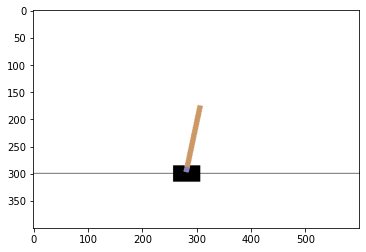

In [23]:
env = gym.make('CartPole-v1')
env.reset()

for i in range(100):
    plt.imshow(env.render(mode='rgb_array'))
    display(plt.gcf())    
    clear_output(wait=True)
    new_state, reward, done, info = env.step(env.action_space.sample()) # take a random action
    if done:
        break

env.close()

Also, have a sense of how a random approach works for this problem.

In [2]:
env = gym.make('CartPole-v1')
env.reset()
total_reward = 0
total_episode = 1000
for episode in range(total_episode):
    env.reset()
    while True:
        new_state, reward, done, info = env.step(env.action_space.sample()) # take a random action
        env.render()
        total_reward += reward
        if done:
            break

env.close()
print("The average reward is {}".format(total_reward / total_episode))

The average reward is 21.897


Note that this is continous task. For this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Though we can somehow discretize the state and apply the *qtable* approach, we'll replace it with a approximator that will approximate the *qtable* lookup function. Thus we can no longer apply the *qtable* for this task. 

As a result, our Q value, $Q(s, a)$ is calculated by passing in a state to the approximator. The output will be Q values for each available action.

We can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$, which is exactly a regression problem.

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ approximator to run the optimizer and update the weights.

Note that since this is a regression task, we can use any regressor we have learned before. At first, we will try to use linear regression for this task. Feel free to use TensorFlow or Pytorch or even the code you have written in previous homework. 

FYI: GPU should provide more efficient training for these models, though a modern CPU should be enough for this homework. Our laptop (i5) can finish all the training tasks in dozens of minutes.

### TODO: implement the Approximator class in *approximator.py* with linear regression

Some useful readings:
* https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
* https://www.tensorflow.org/tutorials/reinforcement_learning/actor_critic

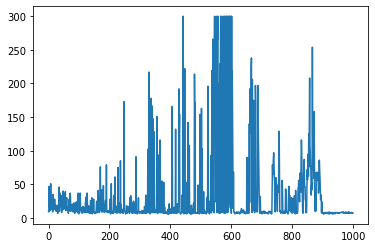

In [19]:
# If you like tensorflow
# from approximator_tf import Approximator
# If you like pytorch (Recommend)
from approximator_torch_linear import Approximator

env = gym.make('CartPole-v1')

gamma = 0.95 # discounting rate

action_size = env.action_space.n
state_size = env.observation_space.shape[0]
# tune the learning_rate and total_episode yourself
# remember how learning_rate can influence the training for NNs?
learning_rate = 0.1
total_episode = 1000
# begin answer
# end answer
model = Approximator(state_size, action_size,
                     learning_rate=learning_rate, memory_pool_size=10000, batch_size=20)

model.train(env, total_episode)
# plot to see the training rewards of each episode
plt.plot(np.arange(len(model.reward_list)), np.array(model.reward_list))
plt.show()

## (Optional) Deep Q-Learning

Observe how linear approximator struggles to learn a good q-function for this task. The reason might be that the Q function for this problem should be a highly non-linear function; thus a linear approximator cannot approximate it well. We should use a more complex approximator. **In many cases, when you want to use a complex approximator, you should consider about neural networks.**

Now we will try to use neural networks as approximator. Feel free to use TensorFlow or Pytorch or even the code you have written in **Assignment3** to implement. Update your Approximator class to use a neural network as the approximator, and rerun the cell above.

Use a simple network should be enough for this a task. An example can be:

State->FC->Relu->FC->Relu->FC->QValue

You can decide the number of neurons yourself, but 64 should be enough.

### TODO: implement a neural network in your Approximator class

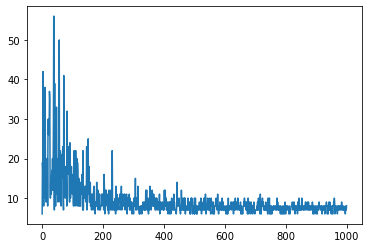

In [20]:
# If you like tensorflow
# from approximator_tf import Approximator
# If you like pytorch (Recommend)
from approximator_torch_dnn import Approximator

env = gym.make('CartPole-v1')

gamma = 0.95 # discounting rate

action_size = env.action_space.n
state_size = env.observation_space.shape[0]
# tune the learning_rate and total_episode yourself
# remember how learning_rate can influence the training for NNs?
learning_rate = 0.1
total_episode = 1000
# begin answer
# end answer
model = Approximator(state_size, action_size,
                     learning_rate=learning_rate, memory_pool_size=10000, batch_size=20)

model.train(env, total_episode)
# plot to see the training rewards of each episode
plt.plot(np.arange(len(model.reward_list)), np.array(model.reward_list))
plt.show()

## Experience Replay

Disappointedly, you may find that the approximator still struggle to converge and get good results. There are several potential reasons for this phenomenon. One reason is that the *new_state* is generated from current *state*, which violates the i.i.d assumption in supervised learning. And this may easily lead to bad convergence performance. One popular strategy for improving the convergence rate and making data more i.i.d is **experience replay**.

Basically, when using **experience replay**, we would like to keep a memory pool filled with the experience the agent had before. More specifically, we would save the *(state, action, reward, new_state, done)* tuple in a memory pool, which denotes the previous experience. For each step of training, we sample a batch of experiences from the memory pool, and train the approximator with this batch. This can be seen as replaying a batch of previous experiences. Also, we would generate a new experience according to the current state and the approximator, and add this new experience to the memory pool.

Note that in this case, the experience an agent has can be used to train the approximator multiple times. In some real-world applications, the experience may be very expensive to gain, and thus experience replay enables a more efficient use of previous experience. Also, as approximator is trained with a batch, the SGD optimizer typically converges more fast.

### TODO: implement experience replay in your Approximator class
Now please complete the **experience_replay** function in your Approximator class, and retrain the approximator. This time, you should find that the approximator can get pretty reasonable results. Check the average reward for each episode below.

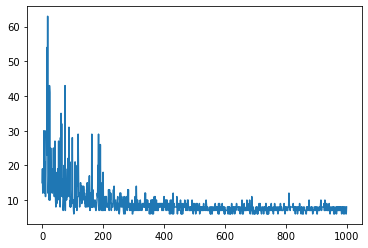

In [21]:
# If you like tensorflow
# from approximator_tf import Approximator
# If you like pytorch (Recommend)
from approximator_torch_dnn_expreplay import Approximator

env = gym.make('CartPole-v1')

gamma = 0.95 # discounting rate

action_size = env.action_space.n
state_size = env.observation_space.shape[0]
# tune the learning_rate and total_episode yourself
# remember how learning_rate can influence the training for NNs?
learning_rate = 0.1
total_episode = 1000
# begin answer
# end answer
model = Approximator(state_size, action_size,
                     learning_rate=learning_rate, memory_pool_size=10000, batch_size=20)

model.train(env, total_episode)
# plot to see the training rewards of each episode
plt.plot(np.arange(len(model.reward_list)), np.array(model.reward_list))
plt.show()

In [155]:
reward_list = model.eval(env, 100)

Average reward per episode is 22.76


Also, it may be interesting to have a look at a demo.

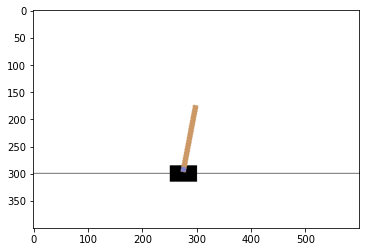

In [156]:
env = gym.make('CartPole-v1')
state = env.reset()

while True:
    plt.imshow(env.render(mode='rgb_array'))
    display(plt.gcf())    
    clear_output(wait=True)
    action = model.take_action(state)
    new_state, reward, done, info = env.step(action)
    state = new_state
    if done:
        break

env.close()

## (Optional) Double Q-Learning

As we only use the same model to both determine the greedy policy and to determine its value, sometimes the model may learn unrealistically high action values because it includes a maximization step over estimated action values, which tends to prefer over-estimated to underestimated values. Imagine that the model learns an over-estimated value for one action, then this action is very more likely to be selected. Further, as the values are estimated with the same model, the updated value for this action is still over-estimated, which makes the other actions difficult to be explored and updated. As a result, the convergence may be slowed down, and even the performance of the final model may be harmed.

As can be seen, the over-estimated problem is partly caused by using the same model to determine the policy and value. Then how can we address this problem? A natural idea is to decouple these two steps by using two different models to determine the policy and value respectively. This is called **double Q-learning**. We call the model that determine the policy as Policy Model and the model that determine the value as Value Model. To avoid introduce an additional network, a very smart trick is like this: when training the models with one episode, we freeze the Value Model and update only the Policy Model. After one episode is trained, we update the Value Model with the weights of the Policy Model. Alternatively, we can update the Value Model with the weights of Policy Model periodically (say, 500 iterations). Although the Policy Model and the Value Model are not fully decoupled in this way, this approach is simple to implement and avoid further network designs. As you will see, this works well in practice.

### TODO: implement double Q-learning in your Approximator class

After implementing the double Q-learning, train another approximator and compare the performance with previous one.

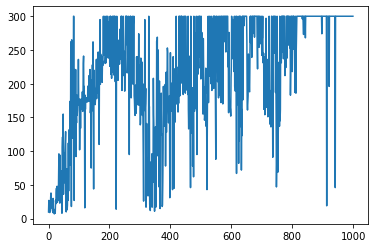

In [17]:
env = gym.make('CartPole-v1')
from approximator_torch_dnn_expreplay_doubleQ import Approximator
# tune the learning_rate yourself
# remember how learning_rate can influence the training for NNs?
learning_rate = 0.1
action_size = env.action_space.n
state_size = env.observation_space.shape[0]
# begin answer
# end answer
gamma = 0.95 # discounting rate
model = Approximator(state_size, action_size,
                     gamma=gamma,
                     learning_rate=learning_rate, 
                     memory_pool_size=10000, 
                     batch_size=128, 
                     init_epsilon=0.9, 
                     min_epsilon=0.05, 
                     epsilon_decay=0.99,
                     double_QLearning=True)#,
                     #double_QLearning_exchange_cnt=5)

model.train(env, 1000)
# plot to see the training rewards of each episode
plt.plot(np.arange(len(model.reward_list)), np.array(model.reward_list))
plt.show()

Check the average rewards

In [18]:
reward_list = model.eval(env, 100)

Average reward per episode is 300.0


Have a look at the demo.

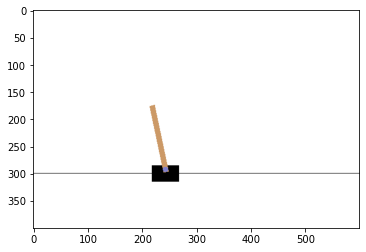

In [27]:
env = gym.make('CartPole-v1')
state = env.reset()

while True:
    plt.imshow(env.render(mode='rgb_array'))
    display(plt.gcf())    
    clear_output(wait=True)
    state = np.expand_dims(state, axis=0)
    action = model.take_action(state)
    new_state, reward, done, info = env.step(action)
    state = new_state
    if done:
        break
        
env.close()

Congratulations! You have finished the journey of reinforcement learning here. There are also some other environments available in *gym* for you to play with. Equipped with the techniques you have learned so far, just feel free to play with them if interested.

Actually, you have learned many practical techniques for reinforcement learning. Theortically, you can even build some famous systems such as AlphaGo mainly based on these techniques :) In AlphaGo, Atari, and many other real-world applications, the agents need to deal with the image/video input. Thus it is naturally to use CNNs as approximators. There are also some other techniques used in these systems, such as Monte Carlo Tree Search in AlphaGo, but the big pictures are similar.

To apply reinforcement learning in real-world problems, there are many other difficulties. I think the biggest challenge may be how to formulate your problems. What are the states? What are the rewards? Are they reasonable enough? How to gain experience? Unlike the environment in this notebook, in real world, these problems are often undefined. You need to formulate them yourself. Another challenge may be that the hyperparameters tuning would be quite difficult, even more difficult than CNNs/RNNs for some typical supervised/unsupervised learning problems. It requires some experience and practice :)

This may be the last assignment for this course. Thank you for participating our course and completing our assignments :)